In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve,classification_report

from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers.data.processors.glue import glue_convert_examples_to_features as convert_examples_to_features
from transformers.data.processors.utils import DataProcessor, InputExample

import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.nn import CrossEntropyLoss,BCEWithLogitsLoss
from tqdm import tqdm_notebook, trange
import pickle
from collections import Counter
from transformers import get_linear_schedule_with_warmup
from torch.optim import optimizer
import os
import sys
import numpy as np
from transformers.optimization import AdamW#, WarmupLinearSchedule

In [68]:
MAX_SEQ_LEN=150

In [30]:
train_df_raw=pd.read_csv(r"C:\Users\Lenovo\Desktop\course codes\AI\ass3\data\train_full.csv")
test_df_raw=pd.read_csv(r"C:\Users\Lenovo\Desktop\course codes\AI\ass3\data\dev_full.csv")

In [45]:
train_df_raw.columns = ['label','user','tweet']
test_df_raw.columns = ['label','user','tweet']
le = LabelEncoder()
le.fit(train_df_raw['label'].tolist())
train_df_raw['label'] = le.transform(train_df_raw['label'].tolist())
test_df_raw['label'] = le.transform(test_df_raw['label'].tolist())

In [5]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [109]:
'''
lenth=[]
for iter in train_df_raw['tweet'].tolist():
    lenth.append(len(bert_tokenizer.tokenize(iter)))
len_list=sorted(Counter(lenth).items(),key=lambda x:x[0])
wordSum=sum(lenth)
wordSumTop=wordSum*0.85
tmpSum=0
MAX_SEQ_LEN=0
for iter in len_list:
    tmpSum=tmpSum+iter[1]*iter[0]
    if tmpSum>wordSumTop:
        MAX_SEQ_LEN=iter[0]
        break
MAX_SEQ_LEN=MAX_SEQ_LEN+2
'''

In [6]:
def get_input(dataset, max_seq_len=MAX_SEQ_LEN):
    pool = ThreadPoolExecutor(max_workers=4)
    def trunate_and_pad(seq, max_seq_len):
        seq = ['[CLS]'] + seq + ['[SEP]']
        seq = bert_tokenizer.convert_tokens_to_ids(seq)
        padding = [0] * (max_seq_len - len(seq))
        seq_mask = [1] * len(seq) + padding
        seq_segment = [0] * len(seq) + padding
        seq += padding
        assert len(seq) == max_seq_len
        assert len(seq_mask) == max_seq_len
        assert len(seq_segment) == max_seq_len
        return seq, seq_mask, seq_segment
    
    sentences = dataset['tweet'].tolist()
    labels = dataset['label'].tolist()
    tokens_seq = list(
            pool.map(bert_tokenizer.tokenize, sentences))
    result = list(
            pool.map(trunate_and_pad, tokens_seq,
                          [max_seq_len] * len(tokens_seq)))
        
    seqs = [i[0] for i in result]
    seq_masks = [i[1] for i in result]
    seq_segments = [i[2] for i in result]
    return seqs, seq_masks, seq_segments, labels

In [69]:
seqs, seq_masks, seq_segments, labels = get_input(dataset=train_df_raw, max_seq_len=MAX_SEQ_LEN)#原来是30
#这里曾经喂错过数据！！！

In [56]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [70]:
t_seqs = torch.tensor(seqs, dtype=torch.long)
t_seq_masks = torch.tensor(seq_masks, dtype = torch.long)
t_seq_segments = torch.tensor(seq_segments, dtype = torch.long)
t_labels = torch.tensor(labels, dtype = torch.long)

train_data = TensorDataset(t_seqs, t_seq_masks, t_seq_segments, t_labels)
train_sampler = RandomSampler(train_data)
train_dataloder = DataLoader(dataset= train_data, sampler= train_sampler,batch_size = 128)

!nvidia-smi
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0
t_seqs.cuda()
t_seq_masks.cuda()
t_seq_segments.cuda()
t_labels.cuda()
tensor = tensor.to(device=torch.device("cuda:0"))
model.cuda()

In [71]:
model.train()
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {
        'params':[p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay':0.01
    },
    {
        'params':[p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay':0.0
    }
]

device = "cpu"#torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-05, correct_bias=True)  # 要重现BertAdam特定的行为，请设置correct_bias = False
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.1, num_training_steps=2000)  # PyTorch调度程序用法如下：


In [82]:
import matplotlib.pyplot as plt

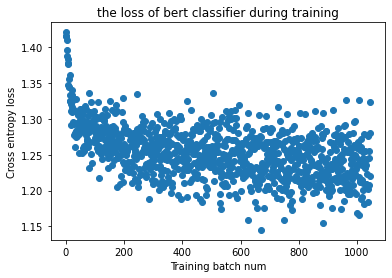

In [91]:

plt.scatter(y=loss_collect,x=list(range(len(loss_collect))))
plt.ylabel("Cross entropy loss")
plt.xlabel("Training batch num")
plt.title("the loss of bert classifier during training")
plt.show()

In [72]:
loss_collect = []
max_grad_norm=1.0
for i in trange(1, desc='Epoch'):
    for step, batch_data in enumerate(tqdm_notebook(train_dataloder, desc='Iteration')):
        batch_data = tuple(t.to(device) for t in batch_data)
        batch_seqs, batch_seq_masks, batch_seq_segments, batch_labels = batch_data
        # 对标签进行onehot编码
        one_hot = torch.zeros(batch_labels.size(0), 4).long()
        one_hot_batch_labels = one_hot.scatter_(
            dim=1,
            index=torch.unsqueeze(batch_labels, dim=1),
            src=torch.ones(batch_labels.size(0), 4).long())
        outputs=model(
            batch_seqs, batch_seq_masks, batch_seq_segments, labels=None)
        logits = outputs.logits.softmax(dim=1)
        
        loss_function = CrossEntropyLoss()
        loss = loss_function(logits, batch_labels)
        loss.backward()
        loss_collect.append(loss.item())
        print("\r%f" % loss, end='')
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-72-d490d6b1fe92>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step, batch_data in enumerate(tqdm_notebook(train_dataloder, desc='Iteration')):


1.220383

Epoch: 100%|██████████| 1/1 [15:25:57<00:00, 55557.59s/it]

In [73]:
torch.save(model,open("fine_tuned_train_bert.bin","wb"))

In [37]:
len(test_seqs)

133795

In [74]:
test_seqs, test_seq_masks, test_seq_segments, test_labels = get_input(dataset=test_df_raw, max_seq_len=MAX_SEQ_LEN)
test_seqs = torch.tensor(test_seqs, dtype=torch.long)
test_seq_masks = torch.tensor(test_seq_masks, dtype = torch.long)
test_seq_segments = torch.tensor(test_seq_segments, dtype = torch.long)

test_labels = torch.tensor(test_labels, dtype = torch.long)
test_data = TensorDataset(test_seqs, test_seq_masks, test_seq_segments, test_labels)
test_dataloder = DataLoader(dataset= test_data, batch_size = 128)
# 用于存储预测标签与真实标签
true_labels = []
pred_labels = []
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [75]:
device = "cpu"#torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [76]:
outputs=None
with torch.no_grad():
    for batch_data in tqdm_notebook(test_dataloder, desc = 'TEST'):
        batch_data = tuple(t.to(device) for t in batch_data)
        batch_seqs, batch_seq_masks, batch_seq_segments, batch_labels = batch_data        
        outputs=model(
            batch_seqs, batch_seq_masks, batch_seq_segments, labels=None)
        cur_pred_labels=outputs.logits.softmax(dim=1).argmax(dim=1).detach().numpy()
        cur_true_labels=batch_labels.detach().numpy()
        pred_labels.append(cur_pred_labels)
        true_labels.append(cur_true_labels)

<ipython-input-76-954fdd6680b9>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_data in tqdm_notebook(test_dataloder, desc = 'TEST'):


In [77]:
print(classification_report(np.concatenate(true_labels), np.concatenate(pred_labels)))       

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1484
           1       0.52      0.65      0.57      4295
           2       0.44      0.63      0.52      4266
           3       0.00      0.00      0.00      1430

    accuracy                           0.47     11475
   macro avg       0.24      0.32      0.27     11475
weighted avg       0.36      0.47      0.41     11475



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
